In [85]:
import pandas as pd
execfile('./optimizer.py')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [113]:
execfile('./price_reader.py')
execfile('./optimizer.py')
execfile('./parser/score_func.py')
execfile('./parser/score_utils.py')

In [49]:
def combine_signals (signals , c_f):
    combined_signal_df = signals[0].copy()
    
    for i in range( signals[0].shape[0] ):
        
        for j in range( signals[0].shape[1] ):
            t = []
            for k in range( len(signals) ) :
                t.append(  signals[k].iloc[i,j] )
            s = c_f(t)
            combined_signal_df.iloc[i,j] = s

    return combined_signal_df    

In [108]:
text_count = pd.read_pickle('../data/signals/text_count.pkl')
s_1a_count = pd.read_pickle('../data/signals/1_sa_count.pkl')
mda_count = pd.read_pickle('../data/signals/mda_count.pkl')

z_text_count = text_count.apply(axis=1,func=getZscore)
z_text_count.fillna(value=np.nan, inplace=True)

z_s_1a_count = s_1a_count.apply(axis=1,func=getZscore)
z_s_1a_count.fillna(value=np.nan, inplace=True)

z_mda_count = mda_count.apply(axis=1,func=getZscore)
z_mda_count.fillna(value=np.nan, inplace=True)




In [110]:
text_vw = pd.read_pickle('../data/signals/text_vw.pkl')
s_1a_vw = pd.read_pickle('../data/signals/1_sa_vw.pkl')
mda_vw = pd.read_pickle('../data/signals/mda_vw.pkl')

z_text_vw = text_vw.apply(axis=1,func=getZscore)
z_text_vw.fillna(value=np.nan, inplace=True)

z_s_1a_vw = s_1a_vw.apply(axis=1,func=getZscore)
z_s_1a_vw.fillna(value=np.nan, inplace=True)

z_mda_vw = mda_vw.apply(axis=1,func=getZscore)
z_mda_vw.fillna(value=np.nan, inplace=True)


In [111]:
text_sent = pd.read_pickle('../data/signals/text_sentiment.pkl')
s_1a_sent = pd.read_pickle('../data/signals/1_sa_sentiment.pkl')
mda_sent = pd.read_pickle('../data/signals/mda_sentiment.pkl')

z_text_sent = text_sent.apply(axis=1,func=getZscore)
z_text_sent.fillna(value=np.nan, inplace=True)

z_s_1a_sent = s_1a_sent.apply(axis=1,func=getZscore)
z_s_1a_sent.fillna(value=np.nan, inplace=True)

z_mda_sent = mda_sent.apply(axis=1,func=getZscore)
z_mda_sent.fillna(value=np.nan, inplace=True)


In [79]:
def mean_f(vec):
    vec = np.array(vec)
    flag = np.isnan(vec).all()
    if flag :
        return np.nan
    else:
         ind = np.where(np.isnan(vec) == False)[0]
         s = np.mean(vec[ind])
         return s       

def max_f(vec):
    vec = np.array(vec)
    flag = np.isnan(vec).all()
    if flag :
        return np.nan
    else:
         ind = np.where(np.isnan(vec) == False)[0]
         s = max(0.0, np.max(vec[ind]) ) + min(0.0, np.min(vec[ind]) )
         return s       

def count_f(vec):
    vec = np.array(vec)
    flag = np.isnan(vec).all()
    if flag :
         return np.nan
    else:
         ind = np.where(np.isnan(vec) == False)[0]
         ind_1 = np.where( (vec[ind]) > 0 ) [0]
         ind_2 = np.where( (vec[ind]) <= 0 ) [0]
         return len(ind_1) - len(ind_2)



In [115]:
opt_dates = z_text_count.index
factor_name = 'F-F_Research_Data_5_Factors_2x3_daily'
tickers = text_count.columns

In [116]:
op_wiz = OptimizationWizard(tickers, factor_name, opt_dates )

In [117]:
def get_stats(signal_df, sec = 'TEXT_VW', adj_alpha = True , opt_type = 'quantile'):
    print sec
    alpha = 0
    
    alpha_tag = ''
    if adj_alpha:
        alpha_tag = 'adj_alpha'
        alpha = op_wiz.getAlpha(signal_df=signal_df,ic=0.5,adj_alpha=True, const_fac=1.0)
    else :   
        alpha_tag = 'unadj_alpha'
        alpha = op_wiz.getAlpha(signal_df=signal_df,ic=0.5,adj_alpha=False, const_fac=1.0)
    
    weights = 0
    if opt_type == 'quantile' :
        weights = op_wiz.getQuantileWeights(alpha, quantile= 0.25)
    
    if opt_type == 'mean_var':
        weights = op_wiz.getMeanVarWeights(alpha)
    
    if opt_type == 'zero_beta':
        weights = op_wiz.getZeroExposueWeights( alpha )
        
    
    p1,f1,a1= op_wiz.runStrategy(weights)
    
    print a1
    
    s1 = a1.mean()/a1.std()


    print 'Information Ratio'
    print s1
    print '------------'

    title = sec + ' ' + alpha_tag + ' ' + opt_type
    pnl = 1 + a1
    pnl = pnl.cumprod()
    
    pylab.plot(opt_dates, pnl)
    pylab.xlabel('time')
    pylab.ylabel('cum pnl')
    pylab.title(title)


In [147]:
c_df_text = combine_signals([z_text_count, z_s_1a_count, z_mda_count], count_f)
c_df_s_1a = combine_signals([z_text_vw, z_s_1a_vw, z_mda_vw], count_f)
c_df_mda = combine_signals([z_text_sent, z_s_1a_sent, z_mda_sent ], count_f)


text
2007-07-01   -0.078201
2008-07-01    0.042470
2009-07-01    0.007024
2010-07-01   -0.055139
2011-07-01   -0.048182
2012-07-01    0.012958
2013-07-01    0.007672
2014-07-01    0.023008
2015-07-01   -0.039142
2016-07-01    0.016553
dtype: float64
Information Ratio
-0.274965312727
------------


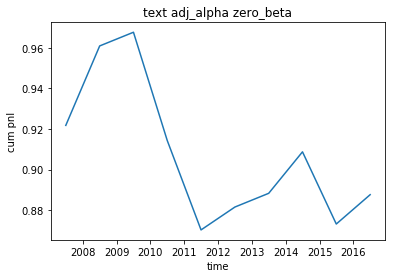

In [149]:
get_stats(signal_df= c_df_mda, sec='text', opt_type='zero_beta', adj_alpha=True)
